# Remote Operation of a Laboratory Experiment via MQTT

## Installations

In [1]:
!pip install paho-mqtt

     |████████████████████████████████| 102kB 3.4MB/s ta 0:00:011
  Created wheel for paho-mqtt: filename=paho_mqtt-1.5.1-cp36-none-any.whl size=61544 sha256=bad3dd55857d971ccfcb4938c41297a53f86ade7baeeee91d82dc4a1973f9629
  Stored in directory: /root/.cache/pip/wheels/75/e2/f5/78942b19b4d135605e58dfe85fba52253b14d636aabf76904b
Successfully built paho-mqtt


## Remote Operation of a Laboratory Experiment

This cell establishes a connection to two topics on an MQTT server. The 'command' channel is used to publish a message to start a remote experiment for a duration given in seconds. A client is opened to listen to a 'measurement' channel.

Before running this channel, start up up the companion notebook that simulates a remote experiment https://colab.research.google.com/drive/1cj9Y8IlVX2-ZMEMoVWi8G5WDKNr3gkr9?usp=sharing 

## Version 1

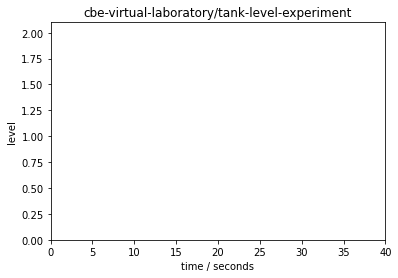

Connected with result code 0


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/jeff/opt/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/jeff/opt/anaconda3/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/paho/mqtt/client.py", line 3452, in _thread_main
    self.loop_forever(retry_first_connection=True)
  File "/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/paho/mqtt/client.py", line 1779, in loop_forever
    rc = self.loop(timeout, max_packets)
  File "/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/paho/mqtt/client.py", line 1181, in loop
    rc = self.loop_read(max_packets)
  File "/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/paho/mqtt/client.py", line 1572, in loop_read
    rc = self._packet_read()
  File "/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/paho/mqtt/client.py", line 2310, in _packet_read

In [4]:
%matplotlib inline
import paho.mqtt.client as mqtt
import paho.mqtt.publish as publish
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

# select experiment duration
duration = 10
topic = "cbe-virtual-laboratory/tank-level-experiment"
client = "plotter"

# setup a plotting window
x = []
y = []
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, '.', ms=10)
ax.set_xlim(0, 40)
ax.set_ylim(0, 2.1)
ax.set_xlabel('time / seconds')
ax.set_ylabel('level')
ax.set_title(topic)
line = ax.lines[0]
display.display(fig)

# callbacks
def on_connect(client, userdata, flags, rc):
    print(f"Connected with result code {rc}")
    client.subscribe(topic)

# call back to process message from remote experiment
def on_message(client, userdata, msg):
    #print(msg.topic + " " + msg.payload.decode("utf-8"))
    xdata, ydata = [float(i) for i in msg.payload.decode("utf-8").split(',')]
    x.append(xdata)
    y.append(ydata)
    line.set_data(x, y)
    display.clear_output(wait=True)
    display.display(fig)

# setup client
client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

# connect to measurement channel
client.connect("mqtt.eclipse.org", 1883, 60)

# tell experiment to start
msg = f'{{"client": "plotter", "duration": {duration}}}'
publish.single(topic + "/command", msg, hostname="mqtt.eclipse.org")

# listen for measurement information
client.loop_start()
time.sleep(duration)
client.loop_stop()

# prevent the plot showing again after completion
plt.close()